# **Experiment with data**

# Grid Search and Simulated annualing

For Jan June and Sept, then continously for March-May 2021 data 


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from Data_for_bp import data_gather_from_files,run_strategy_optimised,run_strategy_eval
import seaborn as sns

In [2]:
Jan_data = data_gather_from_files('1 jan 2021','31 jan 2021')['EURUSD.mid']
June_data = data_gather_from_files('1 june 2021','30 june 2021')['EURUSD.mid']
Sep_data = data_gather_from_files('1 sep 2021','30 sep 2021')['EURUSD.mid']
Cont_data = data_gather_from_files('1 march 2021','31 may 2021')['EURUSD.mid']

## Simulated Annualing

In [14]:
def objective_function(G, n, tick_data):
    profit, U_PNL, max_position, R_PNL = run_strategy_optimised(tick_data, G, n)
    return R_PNL if (max_position <= 10e6 and U_PNL >= -150e3) else float('-inf')

def simulated_annealing(tick_data, initial_temperature, cooling_rate):
       
    #initial guess
    current_G = 0.005
    current_n = 2000000
    
    current_value = objective_function(current_G, current_n, tick_data)
    best_G, best_n, best_value = current_G, current_n, current_value

    temperature = initial_temperature
    no_improve_count = 0

    while temperature > 0.01:
        new_G, new_n = neighbor_solution(current_G, current_n)
        new_value = objective_function(new_G, new_n, tick_data)

        # If the new solution is better or with certain probability based on the difference in objective value and temperature
        if new_value > current_value or np.random.rand() < np.exp((new_value - current_value) / temperature):
            current_G, current_n, current_value = new_G, new_n, new_value

            # Update the best solution if the current one is better
            if current_value > best_value:
                best_G, best_n, best_value = current_G, current_n, current_value

        if new_value > best_value:
            best_G, best_n, best_value = current_G, current_n, current_value
            no_improve_count = 0  # reset the count when a better solution is found
        else:
            no_improve_count += 1
        
        if no_improve_count >= 100:   
            break  # exit the loop if no improvement is seen for a specified number of iterations
            
        temperature *= cooling_rate

    return best_G, best_n, best_value

In [15]:
# intuitive G neighbor solution
def neighbor_solution(G, n):
    delta_G_step = np.random.choice([-0.002,-0.001, 0, 0.001, 0.002])  # G can decrease, stay the same, or increase
    delta_n = np.random.randint(-1000000, 1000000)  
    new_G = np.clip(G + delta_G_step, 0.001, 0.01)  # Ensure G stays within the [0.001, 0.01] range
    new_n = np.clip(n + delta_n, 100000, 5000000)  # Ensure n stays within the [100000, 5000000] range
    return new_G, new_n

In [4]:
initial_temperature = 50
cooling_rate = 0.99

### Jan 2021

In [18]:
best_G, best_n, best_value = simulated_annealing(Jan_data, initial_temperature, cooling_rate)
print(f"Optimal G: {best_G}")
print(f"Optimal n: {best_n}")
print(f"Optimal net profit: {best_value}")

Optimal G: 0.005
Optimal n: 3595673
Optimal net profit: 110117.4857


Computing time : 29m 37.7s

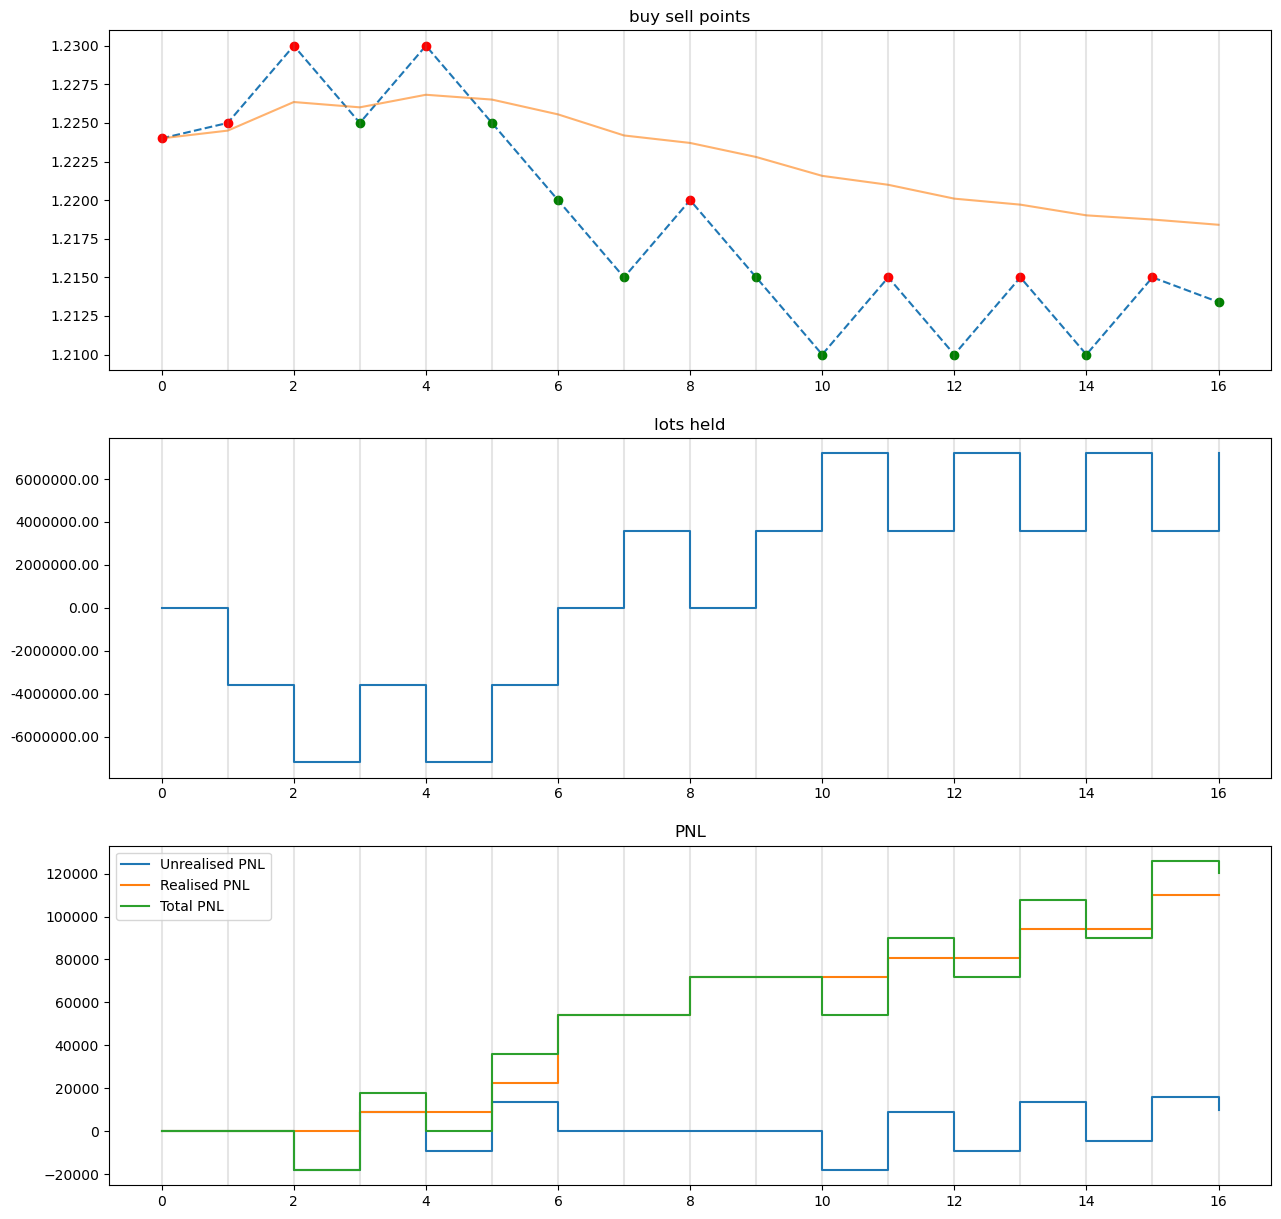

In [19]:
_,a,b,c,d,e,f,g = run_strategy_eval(Jan_data,best_G,best_n,trade_plot=True)

### June 2021

In [16]:
best_G, best_n, best_value = simulated_annealing(June_data, initial_temperature, cooling_rate)
print(f"Optimal G: {best_G}")
print(f"Optimal n: {best_n}")
print(f"Optimal net profit: {best_value}")

Optimal G: 0.007
Optimal n: 2009470
Optimal net profit: 21099.435


Computing time : 18m 44.8s

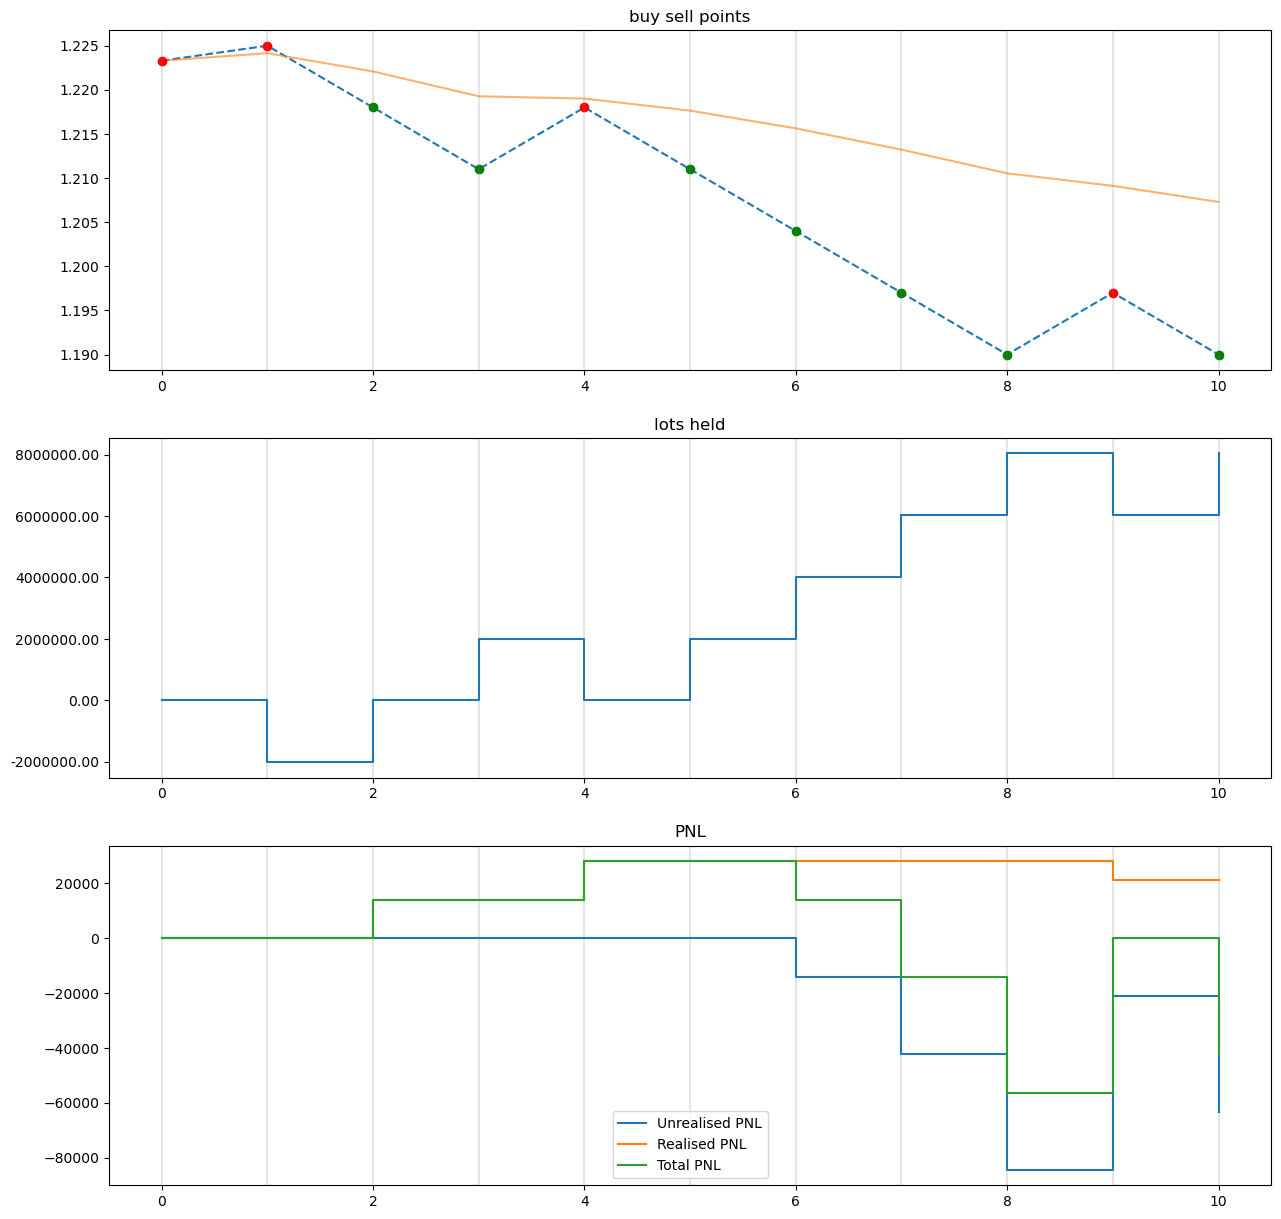

In [17]:
_,a,b,c,d,e,f,g = run_strategy_eval(June_data,best_G,best_n,trade_plot=True)

### Sep 2021

### Using non-intuitive G

In [5]:
best_G, best_n, best_value = simulated_annealing(Sep_data, initial_temperature, cooling_rate)
print(f"Optimal G: {best_G}")
print(f"Optimal n: {best_n}")
print(f"Optimal net profit: {best_value}")

Optimal G: 0.008260108219959993
Optimal n: 3106350
Optimal net profit: 51565.41


Computing time : 17m 17.3s

### Here is the problem when use G intuitive as solutions : Profit drop significantly

In [9]:
run_strategy_optimised(Sep_data,0.008,3106350)

(1242.54, -24850.8, 7206731.999999999, 13046.67)

In [10]:
run_strategy_optimised(Sep_data,0.009,3100000)

(-63240.0, -91140.0, 14386479.999999998, 27900.0)

In [8]:
run_strategy_optimised(Sep_data,0.009,3106350)

(-63369.54, -91326.69, 14415949.079999998, 27957.15)

### lets fix by change neighbor solution to give intuitive G

In [11]:
def neighbor_solution(G, n):
    delta_G_step = np.random.choice([-0.002,-0.001, 0, 0.001,0.002])  # G can decrease, stay the same, or increase
    delta_n = np.random.randint(-1000000, 1000000)  
    new_G = np.clip(G + delta_G_step, 0.001, 0.01)  # Ensure G stays within the [0.001, 0.01] range
    new_n = np.clip(n + delta_n, 100000, 5000000)  # Ensure n stays within the [100000, 5000000] range
    return new_G, new_n

In [12]:
best_G, best_n, best_value = simulated_annealing(Sep_data, initial_temperature, cooling_rate)
print(f"Optimal G: {best_G}")
print(f"Optimal n: {best_n}")
print(f"Optimal net profit: {best_value}")

Optimal G: 0.007
Optimal n: 2780774
Optimal net profit: 38930.836


Computing time: 17m 50.6s

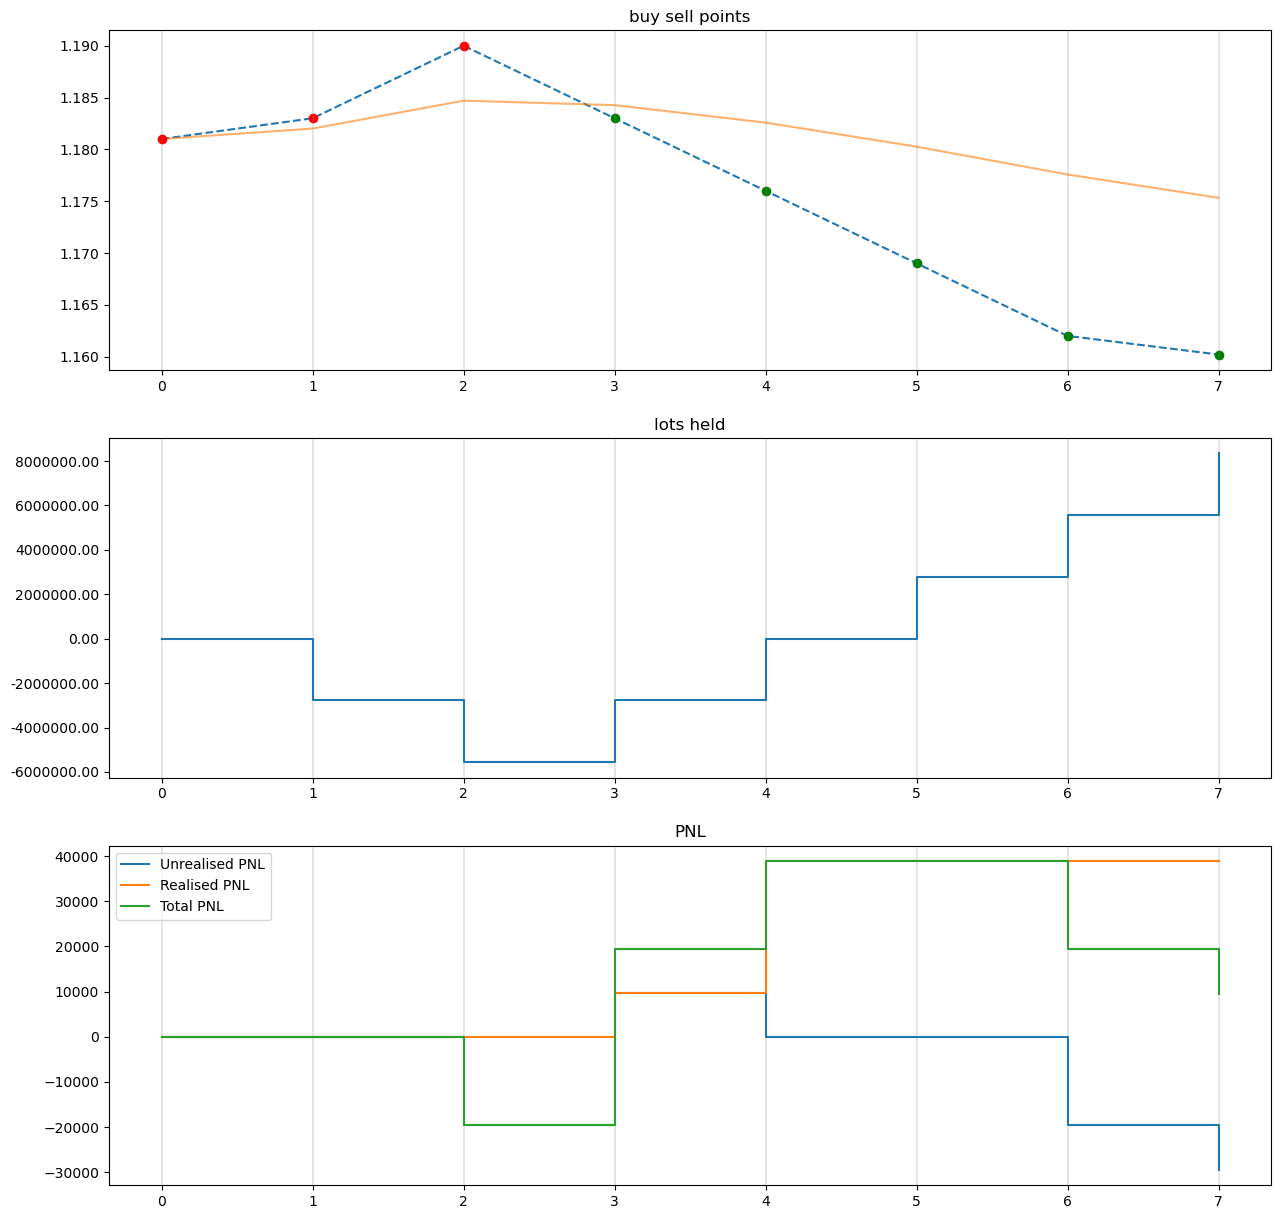

In [13]:
_,a,b,c,d,e,f,g = run_strategy_eval(Sep_data,best_G,best_n,trade_plot=True)

### Continuously from March - May 2021

In [20]:
best_G, best_n, best_value = simulated_annealing(Cont_data, initial_temperature, cooling_rate)
print(f"Optimal G: {best_G}")
print(f"Optimal n: {best_n}")
print(f"Optimal net profit: {best_value}")

Optimal G: 0.01
Optimal n: 4049562
Optimal net profit: 186684.8082


Computing time : 66m 22.6s

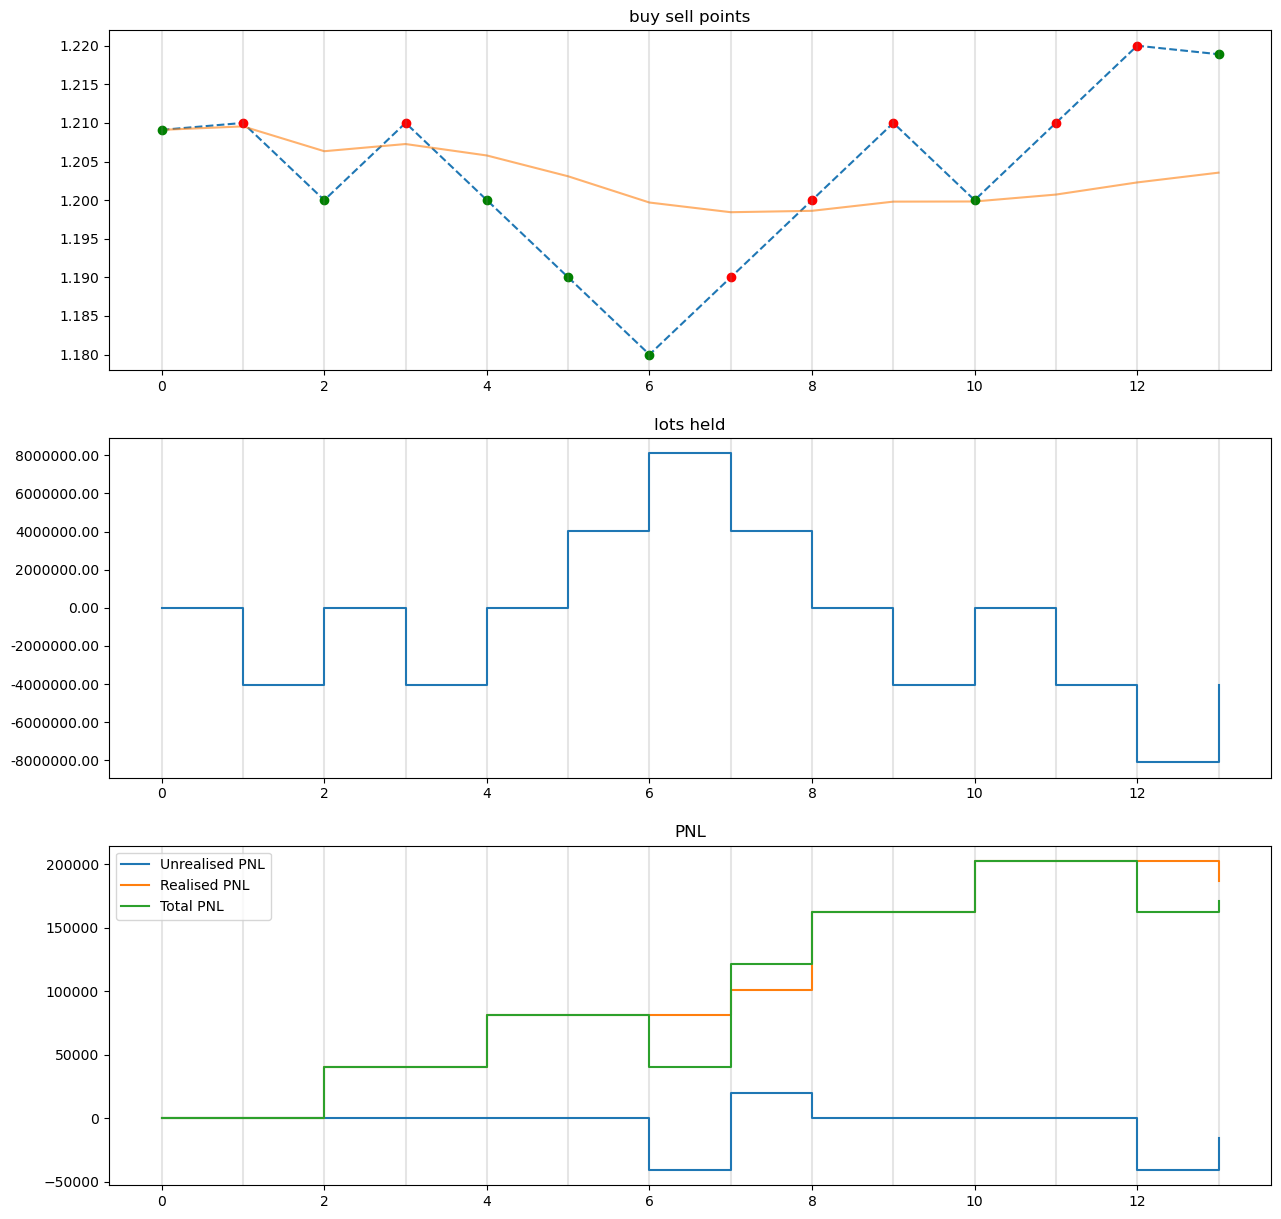

In [21]:
_,a,b,c,d,e,f,g = run_strategy_eval(Cont_data,best_G,best_n,trade_plot=True)

## Grid search

In [ ]:
def profit_heat_map_for_gridsearch(profits, ladder_sizing, position_sizing, title):
    plt.figure(figsize=(10,10))
    
    position_sizing_in_K = np.array(position_sizing) / 1000
    
    ax = sns.heatmap(profits, cbar=True, alpha=0.7)
    
    for i in range(len(ladder_sizing)):
        for j in range(len(position_sizing)):
            ax.text(j+0.5, i+0.5, f"{profits[i, j]:.2f}", 
                    ha='center', va='center', color='black', fontsize=7)
    
    plt.xticks(np.arange(len(position_sizing)) + 0.5, position_sizing_in_K)
    
    rounded_labels = [round(val, 3) for val in ladder_sizing]  # Rounding to 3 decimal places
    plt.yticks(np.arange(len(ladder_sizing)) + 0.5, rounded_labels)
    
    plt.xlabel('Position Sizing (in K)')
    plt.ylabel('Ladder Sizing')
    plt.title(title + ' Heat Map')
    plt.show()


In [ ]:
def optimize_gridsearch(tick_data):
    # For G: Values between 0.001 and 0.01 with an interval of 0.001
    G_values = np.arange(0.001, 0.011, 0.001)
    
    # For n: Values from 100000 to 5000000 with an interval of 500000
    n_values = np.arange(100000, 5000001, 500000)
    
    # Initialize a matrix for storing R_PNL values
    R_PNL_matrix = np.zeros((len(G_values), len(n_values)))
    
    best_profit = float('-inf')
    best_G = None
    best_n = None
    
    # Grid Search
    for i, G in enumerate(G_values):
        for j, n in enumerate(n_values):
            profit, U_PNL, max_position, R_PNL = run_strategy_optimised(tick_data, G, n)
            
            constraint1_okay = (max_position <= 10e6)
            constraint2_okay = (U_PNL >= -150e3)
            
            if constraint1_okay and constraint2_okay:
                R_PNL_matrix[i, j] = R_PNL
                if R_PNL > best_profit:
                    best_profit = R_PNL
                    best_G = G
                    best_n = n
            else:
                R_PNL_matrix[i, j] = np.nan
    result = {
        "best_G": best_G,
        "best_n": best_n,
        "best_profit": best_profit,
        "R_PNL_matrix": R_PNL_matrix,
        "G_values": G_values,
        "n_values": n_values  
    }  
    return result

### Jan 2021

In [ ]:
result = optimize_gridsearch(Jan_data)

if result["best_G"] is not None:
    print(f"Optimal G: {result['best_G']}")
    print(f"Optimal n: {result['best_n']}")
    print(f"Optimal net profit: {result['best_profit']}")
else:
    print("No feasible solution found.")

Optimal G: 0.005
Optimal n: 3600000
Optimal net profit: 110250.0


Computing time: 28m 47.6s

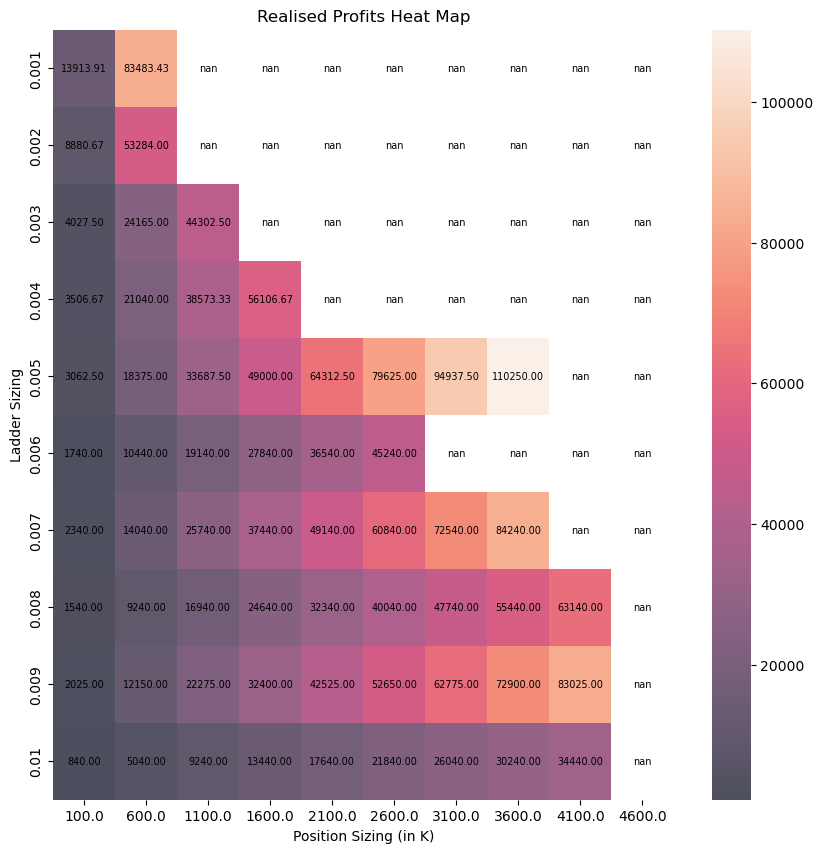

In [ ]:
profit_heat_map_for_gridsearch(
    profits=result['R_PNL_matrix'], 
    ladder_sizing=result['G_values'], 
    position_sizing=result['n_values'], 
    title='Realised Profits'
)

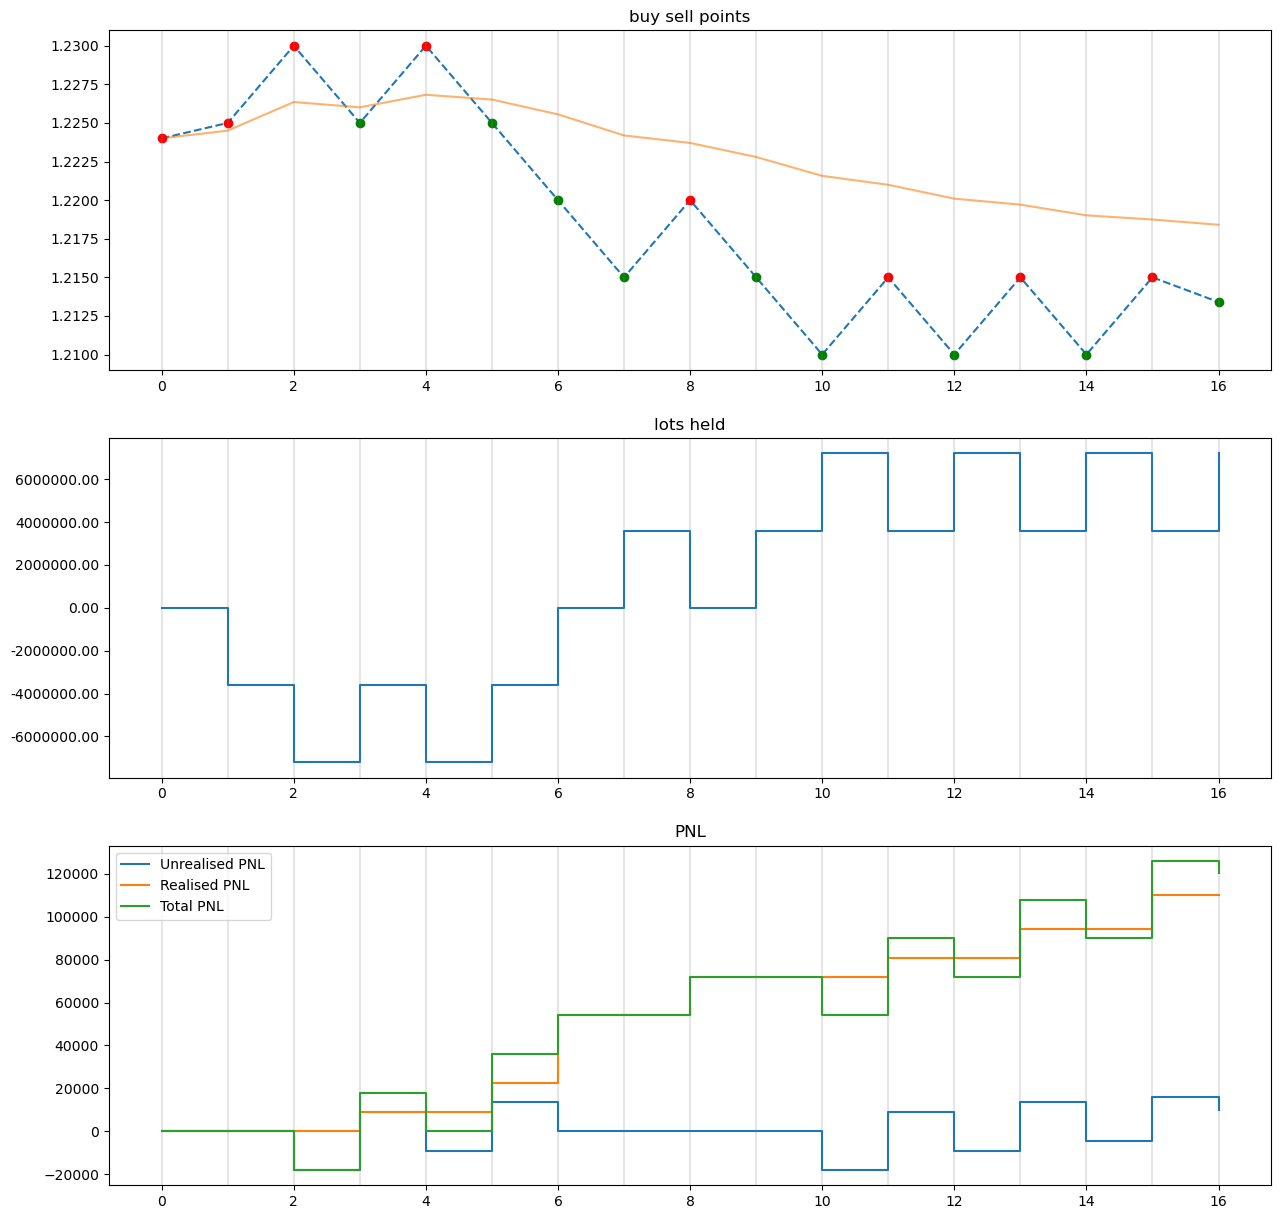

In [ ]:
_,a,b,c,d,e,f,g = run_strategy_eval(Jan_data,result['best_G'],result['best_n'],trade_plot=True)

### June 2021

In [ ]:
result = optimize_gridsearch(June_data)

if result["best_G"] is not None:
    print(f"Optimal G: {result['best_G']}")
    print(f"Optimal n: {result['best_n']}")
    print(f"Optimal net profit: {result['best_profit']}")
else:
    print("No feasible solution found.")

Optimal G: 0.007
Optimal n: 2100000
Optimal net profit: 22050.0


Computing time: 18m 29.8s

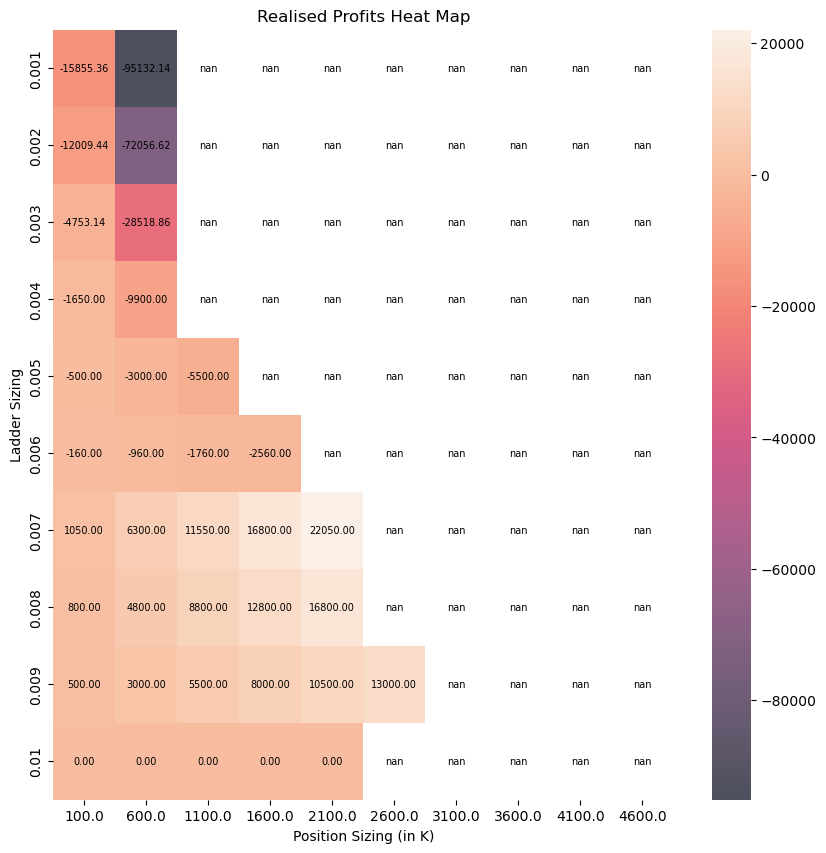

In [ ]:
profit_heat_map_for_gridsearch(
    profits=result['R_PNL_matrix'], 
    ladder_sizing=result['G_values'], 
    position_sizing=result['n_values'], 
    title='Realised Profits'
)

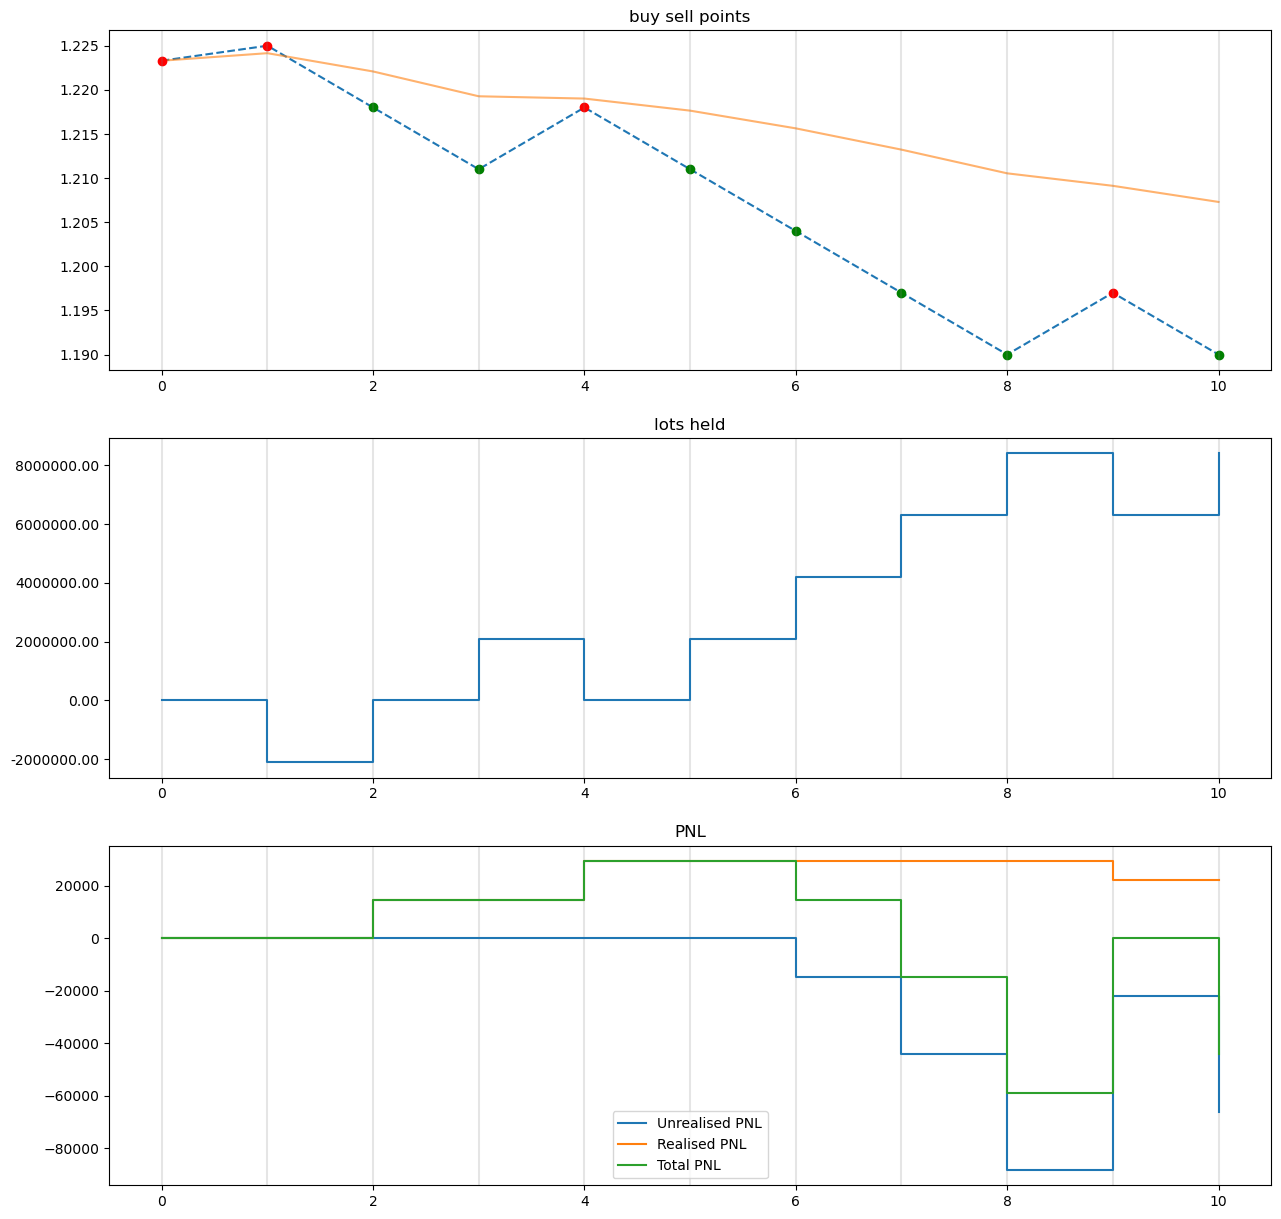

In [31]:
_,a,b,c,d,e,f,g = run_strategy_eval(June_data,result['best_G'],result['best_n'],trade_plot=True)

### Sep 2021

In [35]:
result = optimize_gridsearch(Sep_data)

if result["best_G"] is not None:
    print(f"Optimal G: {result['best_G']}")
    print(f"Optimal n: {result['best_n']}")
    print(f"Optimal net profit: {result['best_profit']}")
else:
    print("No feasible solution found.")

Optimal G: 0.007
Optimal n: 2600000
Optimal net profit: 36400.0


Computing time: 17m 11.1s

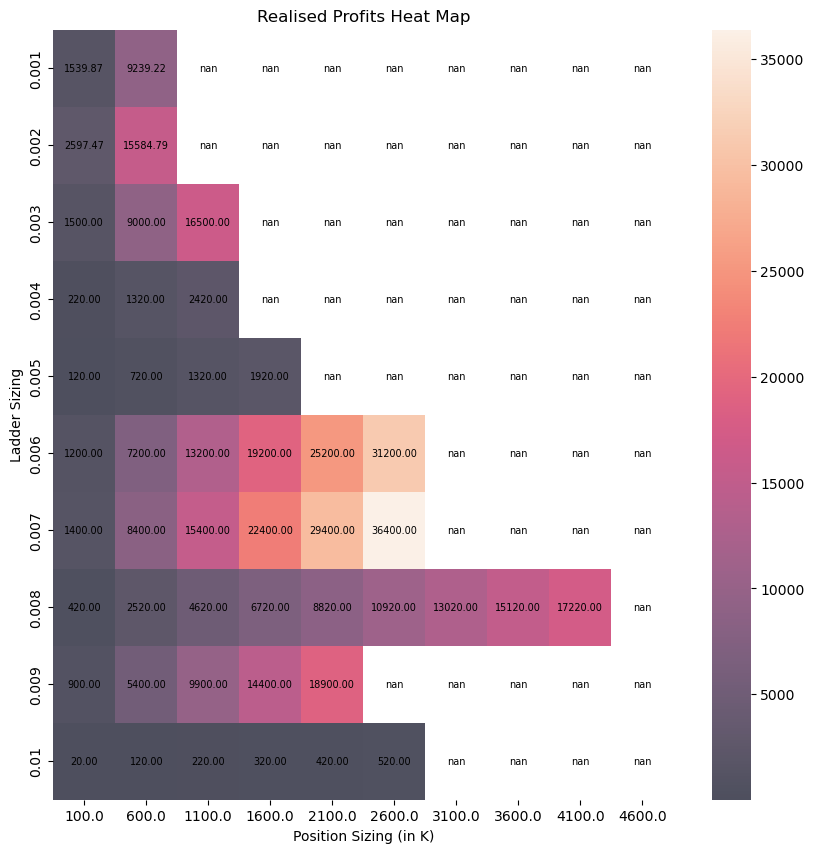

In [36]:
profit_heat_map_for_gridsearch(
    profits=result['R_PNL_matrix'], 
    ladder_sizing=result['G_values'], 
    position_sizing=result['n_values'], 
    title='Realised Profits'
)

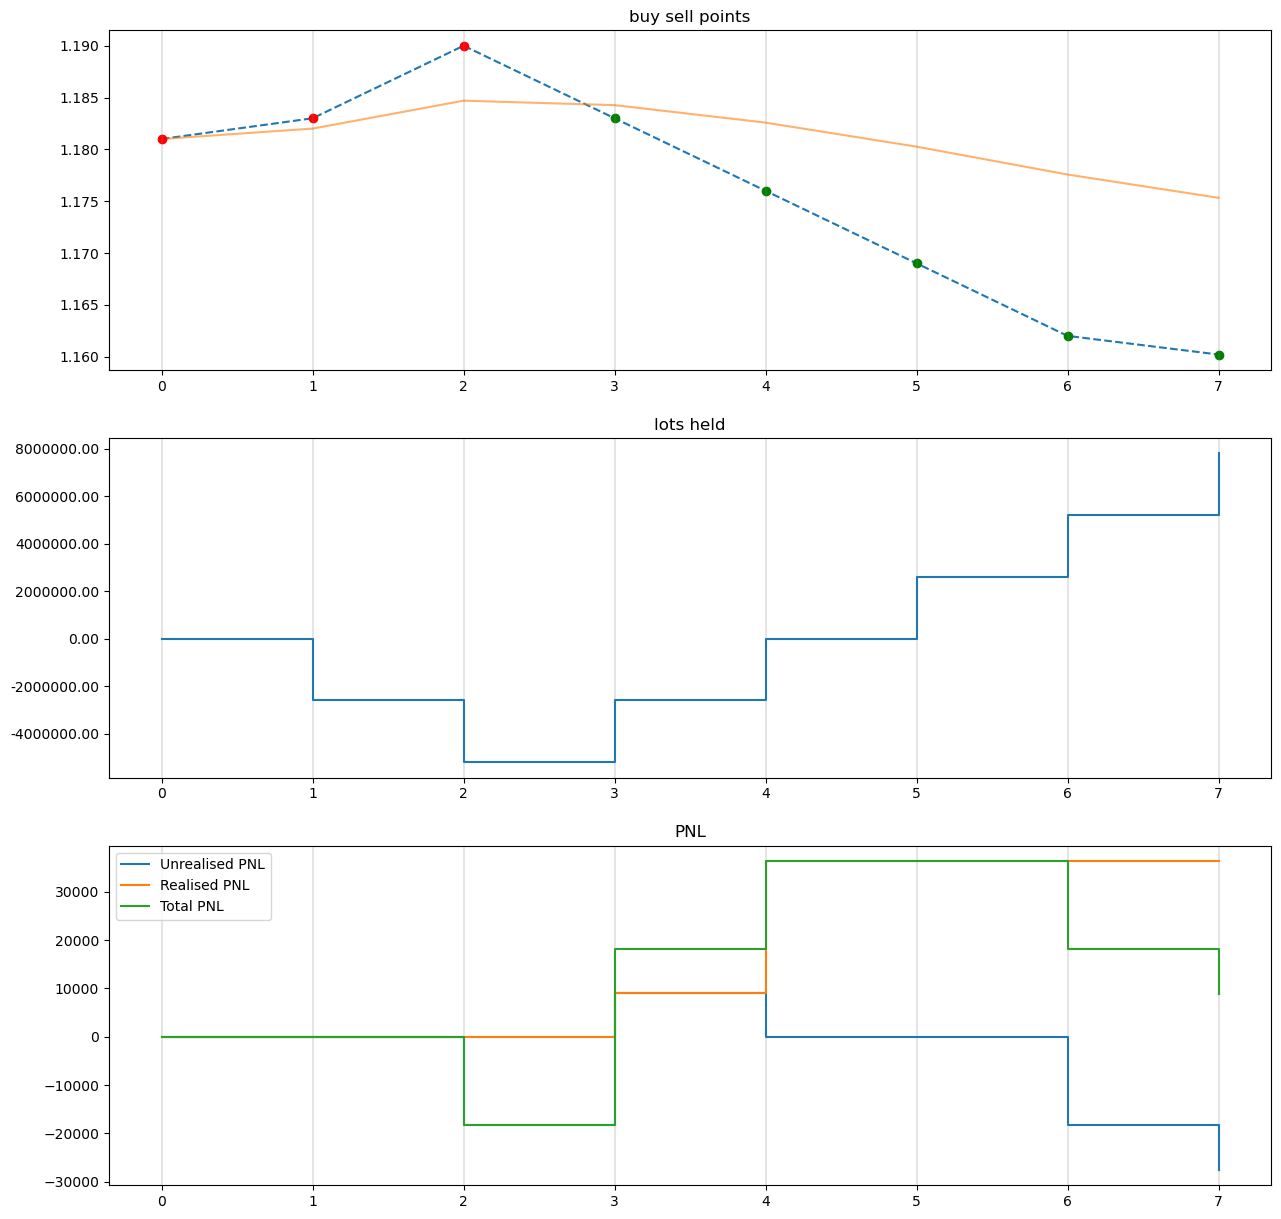

In [37]:
_,a,b,c,d,e,f,g = run_strategy_eval(Sep_data,result['best_G'],result['best_n'],trade_plot=True)

### Continuously from March - May 2021

In [38]:
result = optimize_gridsearch(Cont_data)

if result["best_G"] is not None:
    print(f"Optimal G: {result['best_G']}")
    print(f"Optimal n: {result['best_n']}")
    print(f"Optimal net profit: {result['best_profit']}")
else:
    print("No feasible solution found.")

Optimal G: 0.010000000000000002
Optimal n: 3600000
Optimal net profit: 165960.0


Computing time: 65m 9.8s

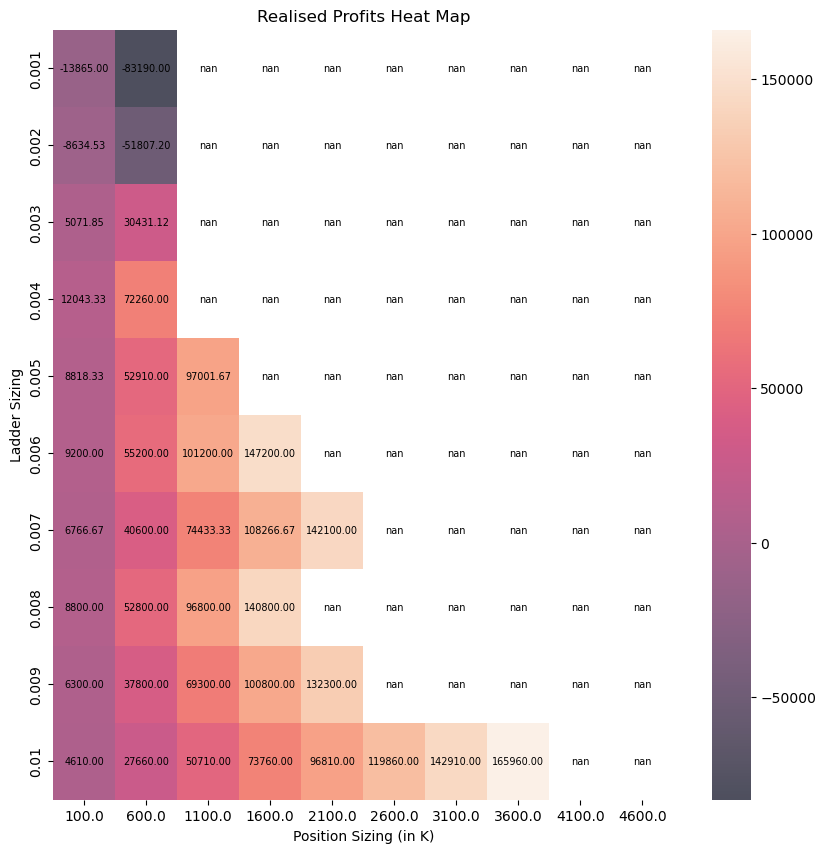

In [39]:
profit_heat_map_for_gridsearch(
    profits=result['R_PNL_matrix'], 
    ladder_sizing=result['G_values'], 
    position_sizing=result['n_values'], 
    title='Realised Profits'
)

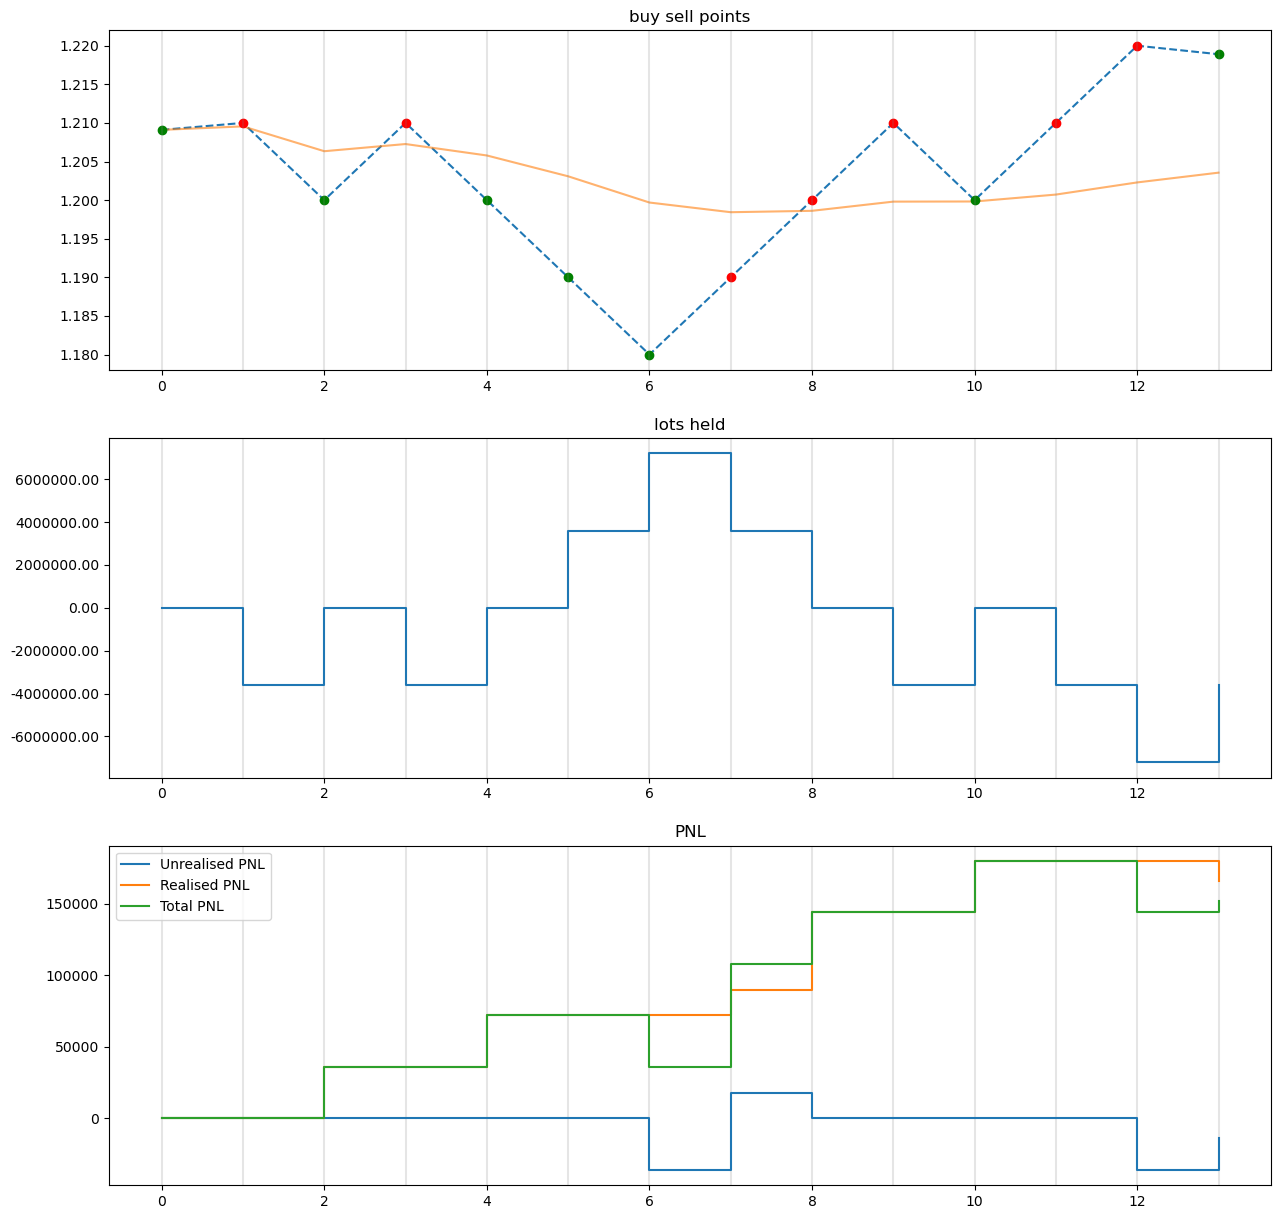

In [40]:
_,a,b,c,d,e,f,g = run_strategy_eval(Cont_data,result['best_G'],result['best_n'],trade_plot=True)